# **Introduction**


-   Healthcare datasets are rich but messy, patient outcomes are often influenced by many factors (e.g., age, smoking history, symptoms, labs), and missing values are common.

-   Accurate risk prediction can support earlier screening and better triage, where model-assisted decisions directly affect care.

-   In this lab, you will build predictive classifiers from numeric patient data: a **Decision Tree** and a **Random Forest** for diabetes outcome. You'll handle missing values inside a Pipeline, then fine-tune to have the best model, lastly evaluate models with Accuracy and F1 and generate test predictions.

<div align="center">

![123](https://hackmd.io/_uploads/BkG_Y60seg.jpg)

</div>

# **Environment**

- Similar to Lab 1, We will be using .ipynb (Jupyter Notebook) files and we recommend using **Anaconda**.

- It's a chance for you the get familiar with Anaconda since our **coding exam** will be using the same.

- If you are unsure about a function or its parameters, you can use help() to view its documentation. For example: help(train_test_split)


# **Requirement**

- Do it individually! Not as a team! (The team is for final project)

- Deadline: **2025/10/9 23:59** (Late submission is not allowed!)

- Hand in following files to eeclass in the following format (Do not compressed!)
	- Lab2.ipynb
	- Lab2_Part1.csv
	- Lab2_Part2.csv

- Lab 2 would be covered on the coding and writing exam next time.

- Responsible TA: Kai-Sheng Chong (cksheng22@gmail.com)
	- Email for questions or visit EECS 639 during TA hours.
	- No debugging service

# **Penalty Rules**

0 points if any of the following conditions happened
- Plagiarism
- Late submission
- Not using the template or importing any other packages
- No code(“Lab2.ipynb”) submission on eeclass
- No prediction csv files submission on eeclass
- Your submission was not generated by your code

5 Points would be deducted if your submission format is incorrect

# **Lab 2: Decision Tree and Random Forest**
In **Lab 2**, you need to finish the following tasks:

1. Part I (50%): Implement a Decision Tree model to predict the diabetes.
> *   Step 1: Load the input data
> *   Step 2: Split data
> *   Step 3: Model Pipeline & Visualization
> *   Step 4: Fine-tuning
> *   Step 5: Predict testing and generate results

2. Part II (45%): Implement a Random Forest model to predict the diabetes.
> *   Step 1: Load the input data
> *   Step 2: Data splitting & Model Training
> *   Step 3: Fine-tuning
> *   Step 4: Predict testing and generate results

3. Part III (5%):
> *  Write a report that answers the given questions.

### Import Packages

⚠️You **cannot** import any other package

In [58]:
import numpy as np
import pandas as pd
import math
import random
import csv
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn import tree
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

### Global attributes
Define the global attributes. You can also add your own global attributes here

In [59]:
part1_output_path = 'Lab2_Part1.csv' # Your model prediction in part I to submit to eeclass
part2_output_path = 'Lab2_Part2.csv' # Your model prediction in part II to submit to eeclass

part1_output =  [] # save your model prediction in part I
part2_output = [] # save your model prediction in part II

# **1. Part I (50%)**
In this part, you need to implement the Decision Tree.

**⚠️Please save the prediction result for the testing data in a CSV file and submit it to eeclass. This file will be used to evaluate your assignment⚠️**

### Step 1: Load the input data

The first step, load the input files.

You can take a look at the input features & the ground truth format:

In [60]:
training_df = pd.read_csv('train.csv')
testing_df = pd.read_csv('test.csv')

display(training_df.head(5))
display(testing_df.head(5))
print("Number of training data: ", len(training_df))
print("Number of testing data: ", len(testing_df))

X = training_df.drop('Outcome', axis=1)
y = training_df['Outcome']

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.0,90.0,62.0,12.0,NaN,27.2,0.580,24.0,0
1,5.0,126.0,78.0,27.0,22.0,29.6,0.439,40.0,0
2,2.0,NaN,58.0,40.0,94.0,34.9,0.225,25.0,0
3,1.0,146.0,56.0,NaN,0.0,29.7,0.564,29.0,0
4,0.0,95.0,64.0,39.0,105.0,44.6,0.366,22.0,0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,7,159,64,0,0,27.4,0.294,40
1,10,68,106,23,49,35.5,0.285,47
2,2,122,76,27,200,35.9,0.483,26
3,7,114,64,0,0,27.4,0.732,34
4,2,74,0,0,0,0.0,0.102,22


Number of training data:  614
Number of testing data:  154


### Step 2: Split data

Use what you have learnt from Lab 1 to split the dataset into a training set and a validation set

**We recommend setting random_state=0 in train_test_split to ensure that the validation data is representative and the evaluation is consistent with the testing data.**

In [61]:
# TODO: Split training_df into training set and validation set
# Hint: stratify=y can be useful
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

### Step 3: Model Pipeline

From the previous step, we can observe that there's missing value **(NaN)** in the training data. To ensure the data consistency and enhance the model performance, it is crucial to handle the missing values well.

To solve the issue, we are using **Imputer** which will fill in missing values in your features so the model can train on a complete feature matrix without dropping rows or columns.

> * **SimpleImputer**: learn a **per-column statistic** on the training data, then replace missing entries with that statistic (mean or median)
> * **KNNImputer**: for each sample with missing values, finds its **k nearest neighbors** using the other features, then imputes the missing entry as the average of those neighbors.

As similar from what we have learnt in Lab 1, we use a Pipeline to combine Imputer and Decision Tree Model so that all preprocessing(imputation) is fit on training inside the pipeline to avoid leakage.

In [62]:
# TODO: Complete the model pipeline
# Hint: Pipeline = SimpleImputer() / KNNImputer() + DecisionTreeClassifier()
dt_base = DecisionTreeClassifier(random_state=0)

pipe_dt = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', dt_base)
])

We first test the pipeline we just built with a simple, reasonable setup to establish a baseline. We uses **Accuracy** and **F1-score** to perform the evaluation on the validation data. Later on we will observe the performance of this base model

In [63]:
# TODO: Fit the pipe_dt
pipe_dt.fit(X_train, y_train)

# TODO: Predict it on X_train and X_val
y_train_pred  = pipe_dt.predict(X_train)
y_val_pred = pipe_dt.predict(X_val)

# TODO: Evaluate on accuracy and f1-score(weighted)
# training accuracy & f1
train_acc  = accuracy_score(y_train, y_train_pred)
train_f1w  = f1_score(y_train, y_train_pred, average='weighted')

# validation accuracy & f1
val_acc  = accuracy_score(y_val, y_val_pred)
val_f1w  = f1_score(y_val, y_val_pred, average='weighted')

print(f"[Base - Training] Acc: {train_acc:.4f} | F1-weighted: {train_f1w:.4f}")
print(f"[Base - Validation] Acc: {val_acc:.4f} | F1-weighted: {val_f1w:.4f}")

[Base - Training] Acc: 1.0000 | F1-weighted: 1.0000
[Base - Validation] Acc: 0.6748 | F1-weighted: 0.6779


#### Visualization

To understand how Decision Tree works, we will produce a few simple plot.

* **Validation Curve**
  * This shows the train and validation accuracy across **max_depth**. If you observe a quick drop after the validation accuracy reached its peak, this is a sign of **overfitting**.
* **Tree preview (first 3 levels)**
  * We visualize the top 3 levels of the trained tree to see which features the tree is relying on early.
* **Feature Importances**
  * This plots a bar chart of the features by importance. Extremely concentrated importance on one or few features can lead to unstable splits.

Based on the visuals above, we will fine-tune the Decision Tree by adjusting the hyperparameters. The goal is to reduce the generalization gap while keeping validation performance and also avoid overfitting.


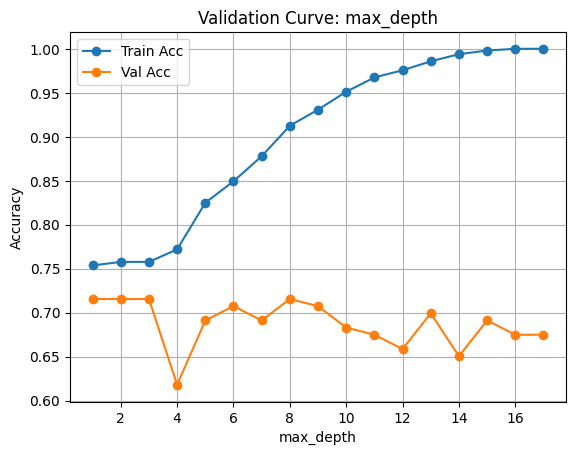

In [64]:
# Validation Curve
# Note: Try locate the turning point on the validation curve.
# Is it a sign of overfitting that the validation score drops?

depths = list(range(1, 18))
train_scores, val_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0, criterion="gini")
    # TODO: Create a pipeline for each depth and also include the imputer
    pipe_clf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', clf)
    ])
    # TODO: Fit the pipeline and do prediction
    pipe_clf.fit(X_train, y_train)
    tr_pred = pipe_clf.predict(X_train)
    va_pred = pipe_clf.predict(X_val)

    train_scores.append(accuracy_score(y_train, tr_pred))
    val_scores.append(accuracy_score(y_val, va_pred))

plt.figure()
plt.plot(depths, train_scores, marker='o', label='Train Acc')
plt.plot(depths, val_scores, marker='o', label='Val Acc')
plt.xlabel('max_depth'); plt.ylabel('Accuracy'); plt.title('Validation Curve: max_depth')
plt.legend(); plt.grid(True); plt.show()


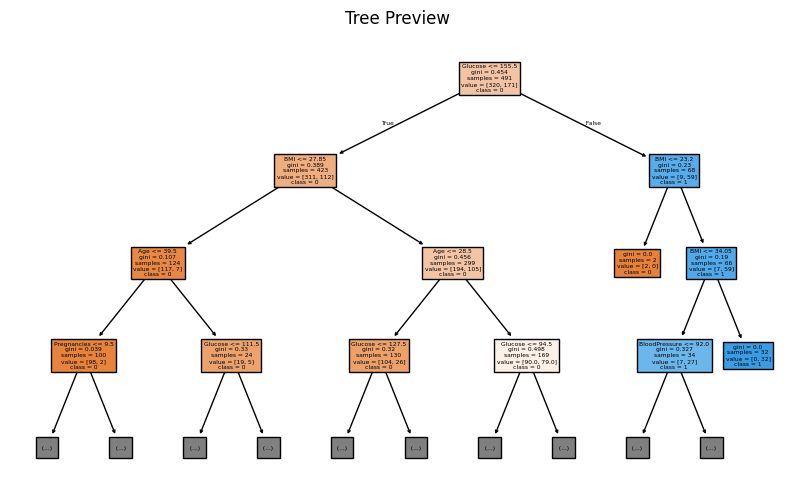

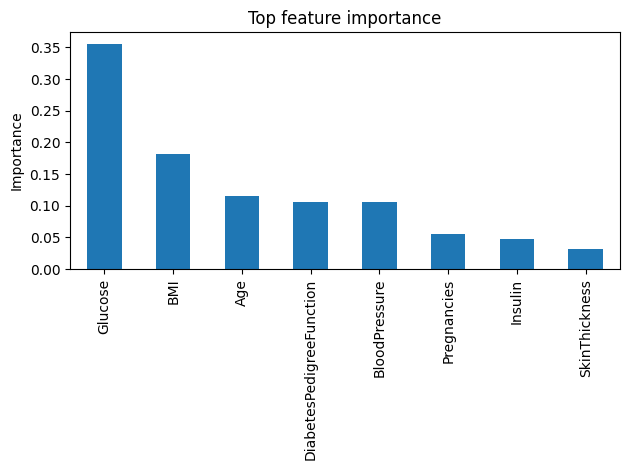

In [65]:
# Tree Preview & Feature importance

plt.figure(figsize=(10, 6))
# TODO: Access the DecisionTreeClassifier from the pipeline (eg. PIPELINE.named_steps[...])
dt_model = pipe_dt.named_steps['model']
# TODO: Plot the DT
plot_tree(
    dt_model,              # Your DT model
    max_depth = 3,         # The levels of the tree
    feature_names = X.columns.tolist(),    # Columns of training data
    class_names = [str(c) for c in dt_model.classes_],      # Y values
    filled = True
)
plt.title('Tree Preview'); plt.show()

# This shows the importance of the features (I've done it for you)
importances = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10).plot(kind='bar')
plt.title('Top feature importance')
plt.ylabel('Importance'); plt.tight_layout(); plt.show()

### Step 4: Fine-tuning

Fine-tuning is a process of choosing a model's hyperparameters. For this lab, we are using **StratifiedKFold** and **GridSearchCV**.

* K-Fold Cross-Validation estimates how well a model generalizes by training/validating on multiple, non-overlapping splits. **StratifiedKFold** keeps each fold with the same class ratios as the full training dataset.

Example: 5 folds Stratified Cross Validation:
<div align="center">

![456](https://hackmd.io/_uploads/rk7apt-hex.png)

</div>

* **GridSearchCV**: It chooses hyperparameters that maximize CV performance. By defining a parameter grid, it runs Stratified K-Fold CV and computes the mean CV score for each combination. It picks the best combination and re-trains the pipeline on the entire training set.

By combining these two steps, we are able to fine-tune our model to improve its overall performance.

---

* **What is the difference of the data splitting in "train-validation split" and "K-fold Cross Validation" ?**
  
  The split in train-validation split is to keep a validation set that we don't use while searching hyperparameters.
  
  On the training split only, we run Stratified K-Fold to evaluate each hyperparameter combo. We choose the hyperparameters that maximize the mean CV score.
  
  So, there's is no conflict between two splitting, as long as the CV is run on the training split only.

---

> Note: Check this reference link to learn about the decision tree classifier hyperparameters   
> * https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [66]:
# TODO: Define param_grid with hyparameters combination
# Hint: Median imputation vs KNN imputation
param_grid = {
    # imputer choice
    'imputer': [
        SimpleImputer(strategy='median'),
        KNNImputer(n_neighbors=5)
    ],

    # tree hyperparameters (these are some common parameters, you can modify it)
    'model__n_estimators': [200, 300],
    'model__max_depth': [None, 5, 7, 9, 12],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}


# TODO: Perform stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestClassifier(random_state=0, n_jobs=-1))
])

# TODO: Implement Grid Search to find out the best parameters
# Note: scoring uses weighted f1-score
gs = GridSearchCV(
    estimator = pipe_rf,
    param_grid = param_grid,
    scoring = 'f1_weighted',
    cv = cv,
    n_jobs = -1,
    refit = True,
    verbose = 0
)

# TODO: Fit the 'gs' model
gs.fit(X_train, y_train)

# Take a look at the best parameters
print("Best params (by F1-weighted):", gs.best_params_)

Best params (by F1-weighted): {'imputer': SimpleImputer(strategy='median'), 'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 6, 'model__n_estimators': 200}


You will receive a full credit for this part if your model performance exceeds our pass mark.
> Acc: 0.68 | F1-weighted: 0.68

In [67]:
# TODO: Predict with the validation data and evaluate the performance
# Hint: Use gs.best_estimator_ as it's the best result from fine-tuning
...
y_val_pred = gs.best_estimator_.predict(X_val)

val_acc  = accuracy_score(y_val, y_val_pred)
val_f1w  = f1_score(y_val, y_val_pred, average='weighted')

print(f"Validation — Acc: {val_acc:.4f} | F1-weighted: {val_f1w:.4f}")

Validation — Acc: 0.7317 | F1-weighted: 0.7207


### Step 5: Predict testing and generate results

Lastly, we want to generate the results and write it to the CSV file.

**Remember to hand in the final output file!!**


In [68]:
# TODO: Refit on all labeled data (X, y) and predict the testing data
# Hint: clone(BEST_ESTIMATOR) and fit it on (X, y)
final_dt = clone(gs.best_estimator_)
final_dt.fit(X, y)

part1_output = final_dt.predict(testing_df)

# Write the predictions to the CSV file
csv_file_path = part1_output_path

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Outcome'])
    for prediction in part1_output:
        writer.writerow([prediction])

# **2. Part II (45%)**

In this part, you need to implement the Random Forest.

**⚠️Please save the prediction result for the testing data in a CSV file and submit it to eeclass. This file will be used to evaluate your assignment⚠️**

### Step 1: Load the input data

Same as Part 1, we load the input file and observe the content of it.

In [69]:
training_df = pd.read_csv('train.csv')
testing_df = pd.read_csv('test.csv')

X = training_df.drop('Outcome', axis=1)
y = training_df['Outcome']

### Step 2: Data splitting & Model Training

The difference between Decision Tree and Random Forest is that RF is an ensemble of many decision trees trained on bootstrap samples with random feature subsets at each split. We use RF when we want a stronger, more stable performance for our model.

* Note:
DT can easily overfit, small changes in data can change the tree. RF typically has higher accuracy and less overfitting than a single tree.

> Note: Check this reference link to learn about the random forest classifier hyperparameters   
> * https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [70]:
# TODO: Split training_df into training set and validation set (random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# TODO: Complete the model pipeline[imputer + rf] (use n_estimators=300)
rf_base = RandomForestClassifier(
    n_estimators=300,
    random_state=0,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight='balanced'
)

pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', rf_base)
])

# TODO: Fit the pipeline and predict the validation data
pipe_rf.fit(X_train, y_train)
y_val_base = pipe_rf.predict(X_val)

# TODO: Evaluate baseline with accuracy and F1-score
base_acc = accuracy_score(y_val, y_val_base)
base_f1w = f1_score(y_val, y_val_base, average='weighted')

print(f"[Baseline RF] Acc: {base_acc:.4f} | F1w: {base_f1w:.4f}")

[Baseline RF] Acc: 0.7073 | F1w: 0.6993


#### Visualization

Similar to part 1, but we observe the accuracy and f1-score across **n_estimators** and **max_depth** here.

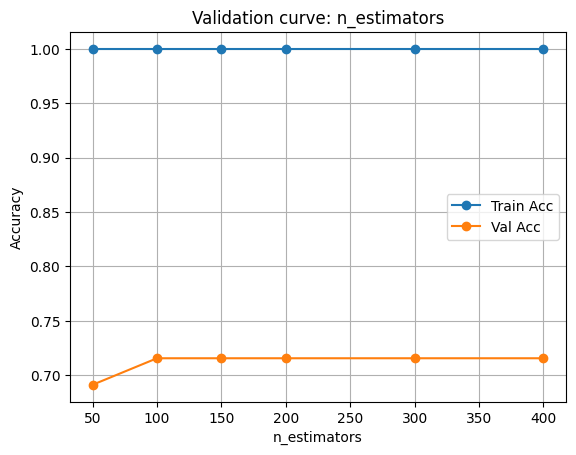

In [71]:
# n_estimators curve
n_list = [50, 100, 150, 200, 300, 400]
tr_scores, va_scores = [], []

for n in n_list:
    clf = RandomForestClassifier(n_estimators=n, random_state=0, n_jobs=-1)
    # TODO: Create a pipeline for each n_estimator to include the imputer
    pipe_clf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', clf)
    ])
    # TODO: Fit the pipeline and do prediction
    pipe_clf.fit(X_train, y_train)
    tr_pred = pipe_clf.predict(X_train)
    va_pred = pipe_clf.predict(X_val)

    tr_scores.append(accuracy_score(y_train, tr_pred))
    va_scores.append(accuracy_score(y_val, va_pred))

plt.figure()
plt.plot(n_list, tr_scores, marker='o', label='Train Acc')
plt.plot(n_list, va_scores, marker='o', label='Val Acc')
plt.xlabel('n_estimators'); plt.ylabel('Accuracy'); plt.title('Validation curve: n_estimators')
plt.legend(); plt.grid(True); plt.show()

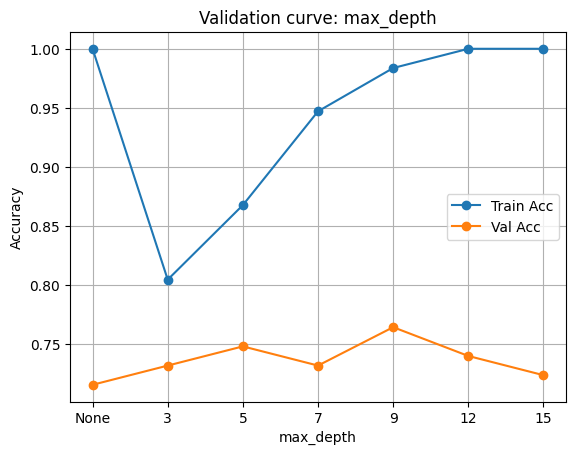

In [72]:
# max_depth curve
depth_list = [None, 3, 5, 7, 9, 12, 15]
tr_scores, va_scores = [], []

for d in depth_list:
    clf = RandomForestClassifier(max_depth=d, n_estimators=150, random_state=0, n_jobs=-1)
    # TODO: Create a pipeline for each depth to include the imputer
    pipe_clf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', clf)
    ])
    # TODO: Fit the pipeline and do prediction
    pipe_clf.fit(X_train, y_train)
    tr_pred = pipe_clf.predict(X_train)
    va_pred = pipe_clf.predict(X_val)

    tr_scores.append(accuracy_score(y_train, tr_pred))
    va_scores.append(accuracy_score(y_val, va_pred))

plt.figure()
plt.plot([str(d) for d in depth_list], tr_scores, marker='o', label='Train Acc')
plt.plot([str(d) for d in depth_list], va_scores, marker='o', label='Val Acc')
plt.xlabel('max_depth'); plt.ylabel('Accuracy'); plt.title('Validation curve: max_depth')
plt.legend(); plt.grid(True); plt.show()

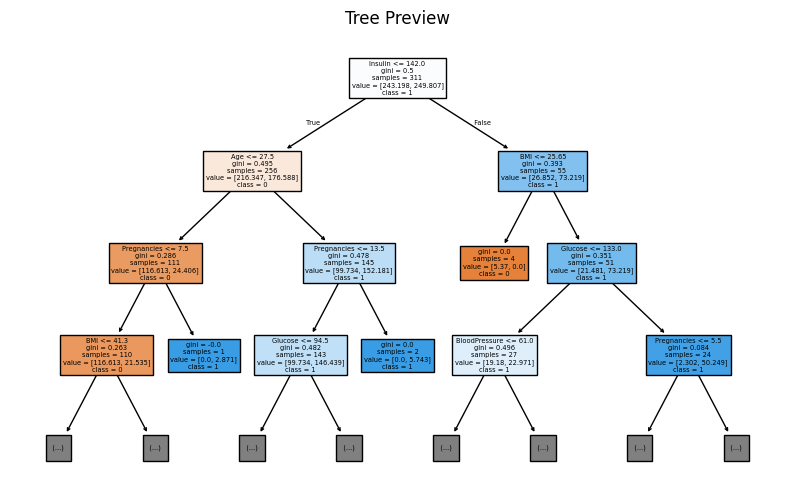

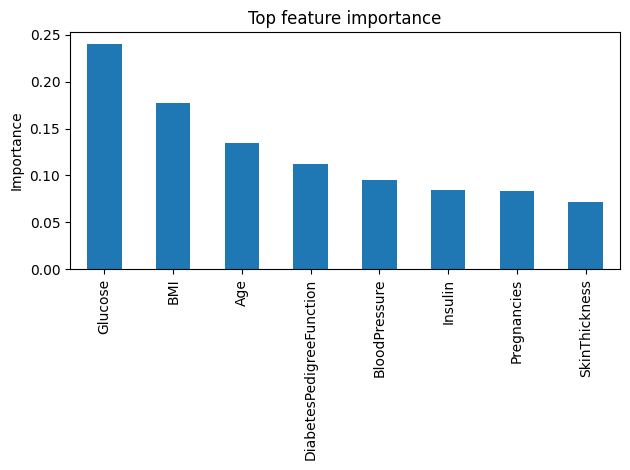

In [73]:
# Tree Preview & Feature importance

plt.figure(figsize=(10, 6))
# TODO: Access the RandomForestClassifier from the pipeline (eg. PIPELINE.named_steps[])
rf_model = pipe_rf.named_steps['model']
# TODO: Plot the RF model
plot_tree(
    rf_model.estimators_[0],       # First tree in the forest
    max_depth=3,
    feature_names=X.columns.tolist(),
    class_names=[str(c) for c in rf_model.classes_],
    filled=True
)
plt.title('Tree Preview'); plt.show()

# This shows the importance of the features (I've done it for you)
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10).plot(kind='bar')
plt.title('Top feature importance')
plt.ylabel('Importance'); plt.tight_layout(); plt.show()

### Step 3: Fine-tuning

For this part, you can use the same method as Part 1, but we introduce a quicker method (but maybe not as good) compared to GridSearchCV to fine-tune our Random Forest Classifier.

> **RandomizedSearchCV** :
> Instead of exhaustively trying every combination (grid search), randomized search samples a fixed number of hyperparameter combinations from a predefined space and evaluates each with Stratified K-Fold CV. This is usually much faster while still finding strong settings. All preprocessing (e.g., Imputer) stays inside the Pipeline so each CV fold is leak-safe.

Reference:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

You will receive a full credit for this part if your final RF model performance exceeds our pass mark. The final RF model is used to predict our testing set, you need to observe which model (before or after fine-tuned) performs the best.
> Acc: 0.70 | F1-weighted: 0.70


In [74]:
# TODO: Define param_grid with hyparameters combination
# Hint: Median imputation vs KNN imputation
# Note: Exhaustively try every combination will cost a lot of time, maybe focus on some specific parameters

param_grid = {
    # imputer choice
    'imputer': [SimpleImputer(strategy='median'), KNNImputer(n_neighbors=5)],

    # tree hyperparameters (these are some common parameters, you can modify it)
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 7, 9],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': [None, 'sqrt', 'log2']
}

# TODO: Perform stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# TODO: Implement Grid Search to find out the best parameters
# Note: scoring uses weighted f1-score
gs = GridSearchCV(
    estimator=Pipeline([('imputer', SimpleImputer()), ('model', RandomForestClassifier(random_state=0, n_jobs=-1))]),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

# TODO: Fit the 'gs' model
gs.fit(X_train, y_train)

# Take a look at the best parameters
print("Best params (by F1-weighted):", gs.best_params_)

# TODO: Predict on the validation set with the best estimators
y_val_pred = gs.best_estimator_.predict(X_val)

val_acc  = accuracy_score(y_val, y_val_pred)
val_f1w  = f1_score(y_val, y_val_pred, average="weighted")
print(f"Validation — Acc: {val_acc:.4f} | F1-weighted: {val_f1w:.4f}")
print(f"Δ Validation — Δ Acc: {val_acc - base_acc:+.4f} | Δ F1-weighted: {val_f1w - base_f1w:+.4f}")

Best params (by F1-weighted): {'imputer': KNNImputer(), 'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Validation — Acc: 0.7154 | F1-weighted: 0.7037
Δ Validation — Δ Acc: +0.0081 | Δ F1-weighted: +0.0045


In [75]:
# GridSearchCV needs a lot of computation since RF is an ensemble of multiple DT
# You can try RandomizedSearchCV

# Try you RandomizedSearchCV implementation here:
param_distributions = {
    'imputer': [SimpleImputer(strategy='median'), KNNImputer(n_neighbors=5)],
    'model__n_estimators': randint(200, 800),
    'model__max_depth': [None, 5, 7, 9, 12, 20],
    'model__min_samples_split': [2, 4, 6, 8, 10],
    'model__min_samples_leaf': [1, 2, 3, 4, 5],
    'model__max_features': ['sqrt', 'log2', None],
    'model__criterion': ['gini', 'entropy', 'log_loss']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rs = RandomizedSearchCV(
    estimator=Pipeline([('imputer', SimpleImputer()), ('model', RandomForestClassifier(random_state=0, n_jobs=-1))]),
    param_distributions=param_distributions,
    n_iter=90,          # increase if you have time (e.g., 64–96)
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    random_state=0,
    refit=True,
    verbose = 0
)

rs.fit(X_train, y_train)

y_val_pred = rs.best_estimator_.predict(X_val)

val_acc  = accuracy_score(y_val, y_val_pred)
val_f1w  = f1_score(y_val, y_val_pred, average="weighted")

print(f"Validation — Acc: {val_acc:.4f} | F1-weighted: {val_f1w:.4f}")
print(f"Δ Validation — Δ Acc: {val_acc - base_acc:+.4f} | Δ F1-weighted: {val_f1w - base_f1w:+.4f}")

Validation — Acc: 0.7317 | F1-weighted: 0.7179
Δ Validation — Δ Acc: +0.0244 | Δ F1-weighted: +0.0186


### Step 4: Predict testing and generate results

Lastly, we want to generate the results and write it to the CSV file.

> **Note: You need to decide which model (before or after fine-tuned) to use for this testing data prediction.**

**Remember to hand in the final output file!!**

In [76]:
# TODO: Refit on all labeled data (X, y) and predict the testing data
final_rf = rs.best_estimator_
final_rf.fit(X, y)             
part2_output = final_rf.predict(testing_df)

# Write the predictions to the CSV file
csv_file_path = part2_output_path

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Outcome'])
    for prediction in part2_output:
        writer.writerow([prediction])

# Part III (5%)

Answer the questions below in the given markdown cell:

1.   Do Decision Trees or Random Forests require you to standardize/normalize continuous features? Answer yes/no and give one sentence why. (Note: We did standardization on data preprocessing during Lab 1)  (1%)

2.   Explain why we need to use **StratifiedKFold** when running **GridSearchCV** during fine-tuning phase. (2%)

3.   Explain why **GridSearchCV** takes longer on a Random Forest than on a single Decision Tree even with the **same hyperparameter grid**. (2%)

### Your answer to the questions

1. No, because those models look at features' values directly and split them, so standardizing/normalizing the features doesn't change how the tree is built

2. Some classes in the data might appear more often than others. If we used regular KFold, some folds might contain mostly one class. StratifiedKFold keeps the same class ratio in each split. Since GridSearchCV chooses hyperparameters that maximize CV performance, using StratifiedKFold gives fairer and more stable accuracy estimates for every hyperparameter setting.

3. Both may have the same number of hyperparameter combinations and use the same number of folds, but for each hyperparameter setting and fold, a decision tree trains only 1 tree, but a random forest trains many trees, so the Random Forest takes much longer because it has to build many trees for every test, while the Decision Tree builds just one each time


# Save the Code File
Please save your code as a Jupyter Notebook file (Lab2.ipynb) and submit it to eeclass along with your prediction files (Lab2_Part1.csv and Lab2_Part2.csv).